<a href="https://colab.research.google.com/github/sandeep-bhukya/Integrated-Vehicle-Counting-Speed-Estimation-License-Plate-Recognition/blob/main/project11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51645 entries, 0 to 51644
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ride_id          51645 non-null  int64 
 1   seat_number      51645 non-null  object
 2   payment_method   51645 non-null  object
 3   payment_receipt  51645 non-null  object
 4   travel_date      51645 non-null  object
 5   travel_time      51645 non-null  object
 6   travel_from      51645 non-null  object
 7   travel_to        51645 non-null  object
 8   car_type         51645 non-null  object
 9   max_capacity     51645 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 3.9+ MB

Missing Values:
ride_id            0
seat_number        0
payment_method     0
payment_receipt    0
travel_date        0
travel_time        0
travel_from        0
travel_to          0
car_type           0
max_capacity       0
dtype: int64

Unique travel_from:
travel_from
Kisii        226

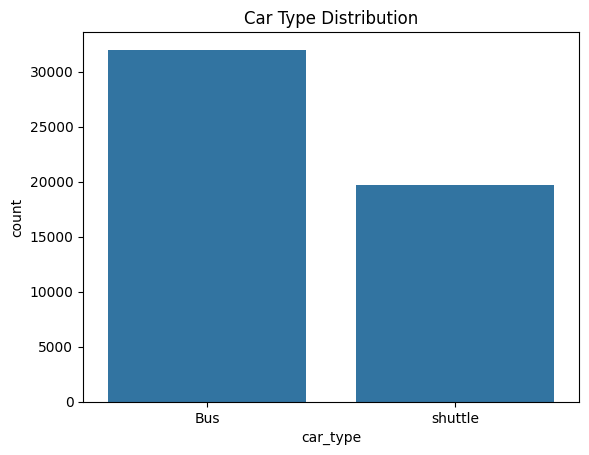


Model Evaluation:
MSE: 53.998993429299375
MAE: 4.473381687907753
R2 Score: 0.33509205465877456


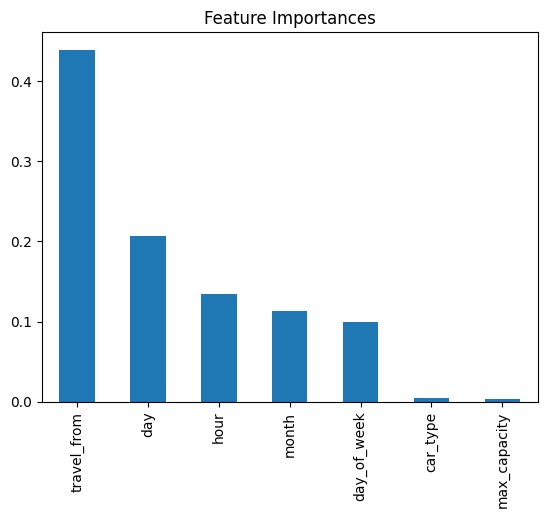

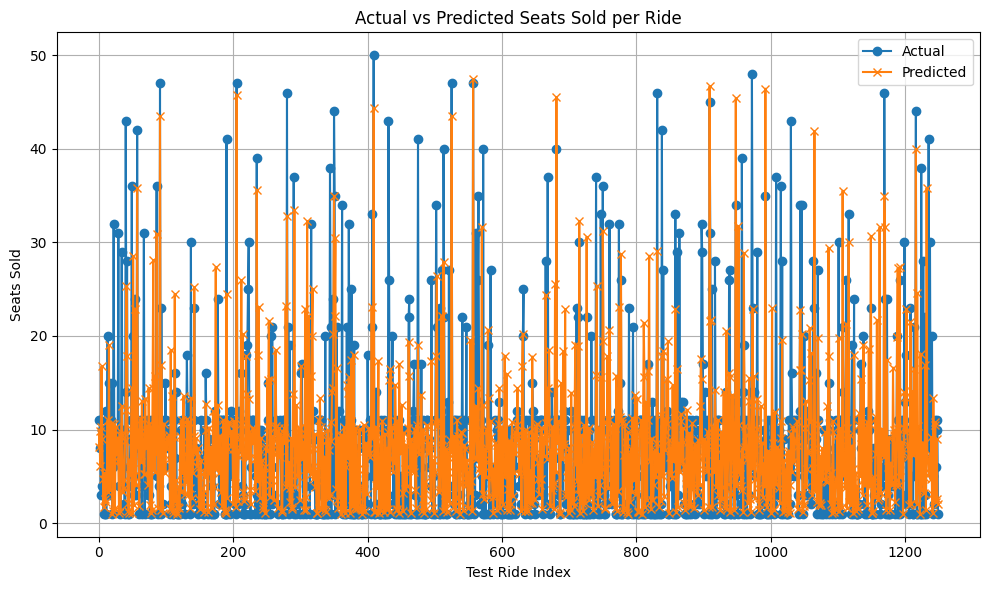

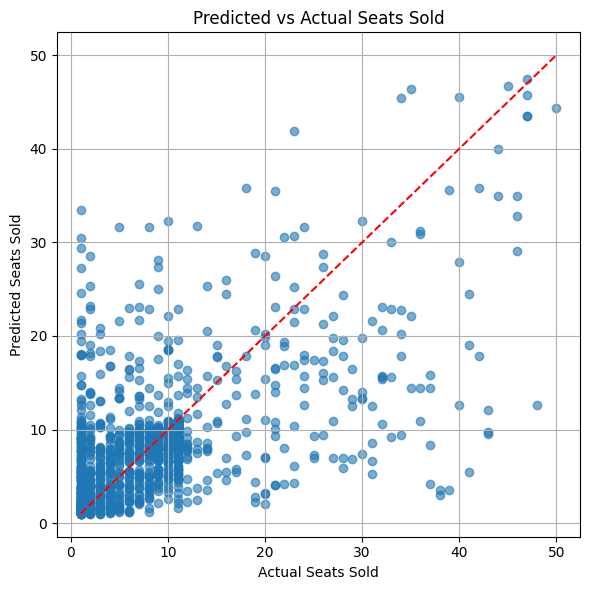

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.linear_model import Ridge

# Load data
df = pd.read_csv("/content/datap1.csv")
# 1. EDA (Exploratory Data Analysis)

print("\nData Info:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

print("\nUnique travel_from:")
print(df['travel_from'].value_counts())

# Distribution of car types
sns.countplot(data=df, x='car_type')
plt.title("Car Type Distribution")
plt.show()


# 2. Clean-Up
# Convert travel_date and travel_time to datetime
df['travel_date'] = pd.to_datetime(df['travel_date'], dayfirst=True)
df['travel_time'] = pd.to_datetime(df['travel_time'], format='%H:%M').dt.time

# Drop duplicates and irrelevant columns
df.drop(['seat_number', 'payment_receipt', 'payment_method'], axis=1, inplace=True)


# 3. Feature Engineering

# Extract date parts
df['day_of_week'] = df['travel_date'].dt.dayofweek
df['day'] = df['travel_date'].dt.day
df['month'] = df['travel_date'].dt.month

# Convert travel_time to hour for simplicity
df['hour'] = pd.to_datetime(df['travel_time'], format='%H:%M:%S').apply(lambda x: x.hour)

# Grouping to get target variable: seats sold per ride
ride_df = df.groupby(['ride_id', 'travel_date', 'travel_from', 'car_type', 'max_capacity', 'day_of_week', 'day', 'month', 'hour']).size().reset_index(name='seats_sold')

# 4. Pre-Processing

# Encode categorical variables
le = LabelEncoder()
ride_df['travel_from'] = le.fit_transform(ride_df['travel_from'])
ride_df['car_type'] = le.fit_transform(ride_df['car_type'])

# Features and target
X = ride_df.drop(['seats_sold', 'ride_id', 'travel_date'], axis=1)
y = ride_df['seats_sold']

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Model Implementation

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

#  Model Evaluation
print("\nModel Evaluation:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:",mean_absolute_error(y_test,y_pred))

print("R2 Score:", r2_score(y_test, y_pred))


# 6. Model Explainability

# Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title("Feature Importances")
plt.show()
# 7. Predicted vs Actual Visualization
import matplotlib.pyplot as plt

# Convert back from scaled data to DataFrame for plotting
y_test_reset = y_test.reset_index(drop=True)
y_pred_series = pd.Series(y_pred, name="Predicted")

# Combine actual vs predicted for plotting
comparison_df = pd.concat([y_test_reset, y_pred_series], axis=1)
comparison_df.columns = ['Actual', 'Predicted']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'].values, label='Actual', marker='o')
plt.plot(comparison_df['Predicted'].values, label='Predicted', marker='x')
plt.title("Actual vs Predicted Seats Sold per Ride")
plt.xlabel("Test Ride Index")
plt.ylabel("Seats Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# scatter plot for actual vs predicted seat sold
plt.figure(figsize=(6, 6))
plt.scatter(comparison_df['Actual'], comparison_df['Predicted'], alpha=0.6)
plt.plot([comparison_df['Actual'].min(), comparison_df['Actual'].max()],
         [comparison_df['Actual'].min(), comparison_df['Actual'].max()],
         color='red', linestyle='--')  # 45-degree line
plt.title("Predicted vs Actual Seats Sold")
plt.xlabel("Actual Seats Sold")
plt.ylabel("Predicted Seats Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

